In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.saving import save_model, load_model

In [2]:
# --- CONFIGURAÇÃO INICIAL ---
df = yf.Ticker('BOVA11.SA')
hoje = datetime.date.today()
start_date = hoje.replace(year=hoje.year - 4, month=1, day=1)
# Definir o período desejado (de 2018 até hoje)
start_date = '2018-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

bd = df.history(start=start_date, end=end_date)
bd_2 = df.history(period="2d", interval='1m')

if bd.index[-1].date() != bd_2.index[-1].date():
    bd = pd.concat([bd, bd_2.tail(1)], axis=0)

bd['Date'] = pd.to_datetime(bd.index).date 
bd.reset_index(drop=True, inplace=True)
bd_fec = bd[['Date','Close']].copy()

In [3]:
# --- ESCALONAMENTO MANUAL ---
me = bd['Close'].mean()
amp = bd['Close'].max() - bd['Close'].min()
df_scaled = ((bd['Close'] - me)/amp).to_numpy().reshape(-1, 1)

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps, 0])
    return np.array(dataX), np.array(dataY)

steps = 15
X, Y = create_df(df_scaled, steps)
train_size = len(X) - 25
Xtrain = X[0:train_size]
Ytrain = Y[0:train_size]
Xtest = X[train_size:]
Ytest = Y[train_size:]

# Reshape
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [4]:
# --- MODELO ---
model = Sequential()
model.add(LSTM(128, activation=LeakyReLU(alpha=0.04), return_sequences=True, input_shape=(steps, 1)))
model.add(Dropout(0.03))
model.add(LSTM(64, activation=LeakyReLU(alpha=0.03), return_sequences=True))
model.add(Dropout(0.02))
model.add(LSTM(32, activation=LeakyReLU(alpha=0.02), return_sequences=False))
model.add(Dropout(0.01))
model.add(Dense(1, activation=LeakyReLU(alpha=0.01)))

model.compile(optimizer='adam', loss='mse')

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

validation = model.fit(
    Xtrain, Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=100, # Reduzi para teste rápido, mantenha o seu valor original
    batch_size=16,
    callbacks=[early_stopping_callback],
    verbose=0 # Deixei 0 para limpar o output, mude para 1 se quiser ver o treino
)

# 1. Pede para o modelo avaliar os dados de teste AGORA
resultado_atual = model.evaluate(Xtest, Ytest, verbose=0)
loss_atual = resultado_atual[0] if isinstance(resultado_atual, list) else resultado_atual

# 2. Busca qual foi o menor valor de 'val_loss' registrado no histórico
melhor_loss_historico = min(validation.history['val_loss'])
pior_loss_historico = validation.history['val_loss'][-1] # O da última época

print(f"Loss do modelo atual na memória: {loss_atual:.6f}")
print(f"Melhor Loss registrado no histórico: {melhor_loss_historico:.6f}")
print(f"Loss da última época (100): {pior_loss_historico:.6f}")

c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Bolsa de Valores\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Bolsa de Valores\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Loss do modelo atual na memória: 0.000323
Melhor Loss registrado no histórico: 0.000323
Loss da última época (100): 0.000878


In [5]:
# ==============================================================================
# TÉCNICA: MONTE CARLO DROPOUT (Incerteza do Modelo)
# ==============================================================================

print("Iniciando Simulação Monte Carlo Dropout...")

n_future = 10
n_simulations = 500  # Quantas "versões" da rede vamos consultar
mc_predictions = []  # Vai guardar todas as simulações (500 x 10)

# Última janela conhecida (Ponto de partida)
# Convertendo para tensor para ser compatível com a chamada direta do modelo
initial_input_tensor = tf.convert_to_tensor(df_scaled[-steps:].reshape(1, steps, 1), dtype=tf.float32)

for i in range(n_simulations):
    # Caminho temporário para esta simulação específica
    current_path = []
    current_input = initial_input_tensor # Reseta para o começo a cada simulação
    
    for f in range(n_future):
        # O PULO DO GATO: training=True força o Dropout a ficar ativo
        # Isso faz com que cada loop use um conjunto diferente de neurônios
        pred_tensor = model(current_input, training=True) 
        
        pred_value = pred_tensor.numpy()[0][0]
        current_path.append(pred_value)
        
        # Atualiza a janela deslizante para o próximo dia (Recursivo)
        # Remove o primeiro, adiciona o novo no fim
        new_step = tf.reshape(pred_value, (1, 1, 1))
        current_input = tf.concat([current_input[:, 1:, :], new_step], axis=1)
    
    mc_predictions.append(current_path)

# Transforma em array numpy [500 simulações, 10 dias]
mc_predictions = np.array(mc_predictions)

# ==============================================================================
# CÁLCULO ESTATÍSTICO (Média +/- 1.96 SD)
# ==============================================================================

# Calcula estatísticas por dia (coluna por coluna)
mean_preds = np.mean(mc_predictions, axis=0)
std_preds = np.std(mc_predictions, axis=0)

# Define intervalo (Assumindo Normalidade nas variações da rede)
z_score = 1.96
lower_bound = mean_preds - (z_score * std_preds)
upper_bound = mean_preds + (z_score * std_preds)

# Desfaz a escala (Inverse Transform)
final_mean = mean_preds * amp + me
final_lower = lower_bound * amp + me
final_upper = upper_bound * amp + me

Iniciando Simulação Monte Carlo Dropout...


        Date  Predict_Mean    Lower_IC    Upper_IC   Std_Dev
0 2026-01-30    178.843675  173.857669  183.829680  2.543879
1 2026-02-02    179.017887  171.689354  186.346420  3.739045
2 2026-02-03    179.463862  171.009959  187.917765  4.313217
3 2026-02-04    179.762992  170.610713  188.915271  4.669530
4 2026-02-05    180.174754  170.728541  189.620966  4.819496
5 2026-02-06    180.547349  170.558336  190.536362  5.096435
6 2026-02-09    181.080616  170.884539  191.276693  5.202079
7 2026-02-10    181.296719  170.727366  191.866072  5.392527
8 2026-02-11    181.630033  171.021091  192.238976  5.412725
9 2026-02-12    181.692876  170.470441  192.915311  5.725733


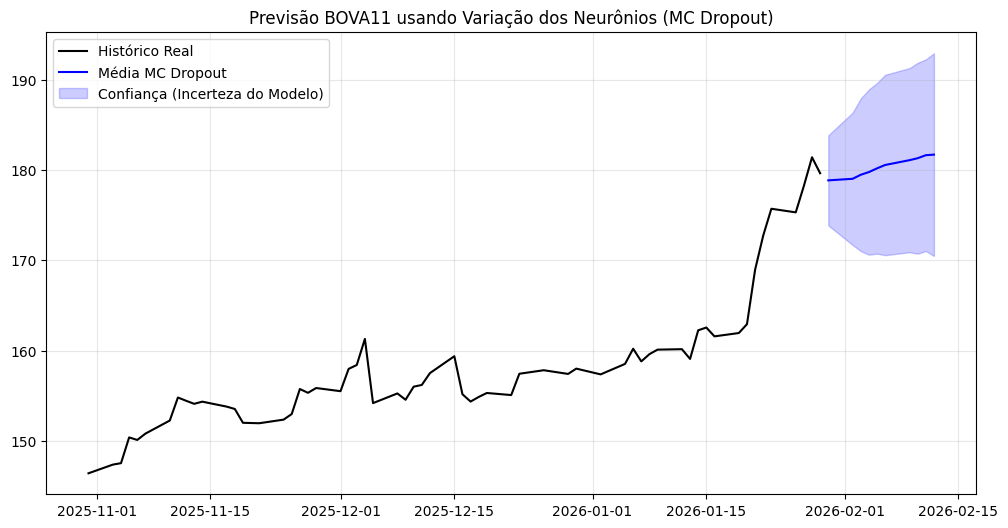

In [6]:
# ==============================================================================
# MONTAGEM DO DATAFRAME E PLOT
# ==============================================================================

dates = pd.to_datetime(bd['Date'])
last_date = dates.iloc[-1]
predict_dates = pd.date_range(last_date + pd.DateOffset(1), periods=10, freq='b').tolist()

df_result = pd.DataFrame({
    'Date': predict_dates,
    'Predict_Mean': final_mean,
    'Lower_IC': final_lower,
    'Upper_IC': final_upper,
    'Std_Dev': std_preds * amp # Apenas para curiosidade
})

print(df_result)

# Plot Rápido
plt.figure(figsize=(12, 6))
# Histórico recente
plt.plot(bd['Date'].iloc[-60:], bd['Close'].iloc[-60:], label='Histórico Real', color='black')
# Previsão
plt.plot(df_result['Date'], df_result['Predict_Mean'], label='Média MC Dropout', color='blue')
# Intervalo
plt.fill_between(df_result['Date'], df_result['Lower_IC'], df_result['Upper_IC'], color='blue', alpha=0.2, label='Confiança (Incerteza do Modelo)')
plt.title('Previsão BOVA11 usando Variação dos Neurônios (MC Dropout)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()